## Problema 1:
Determine los desplazamientos de los bordes libres y los esfuerzos en función de la posición para la
placa empotrada mostrada en la figura. Tome las dos particiones en elementos mostradas debajo y
compare los resultados. Asuma que E = 30 x 106 psi y n = 0.30.
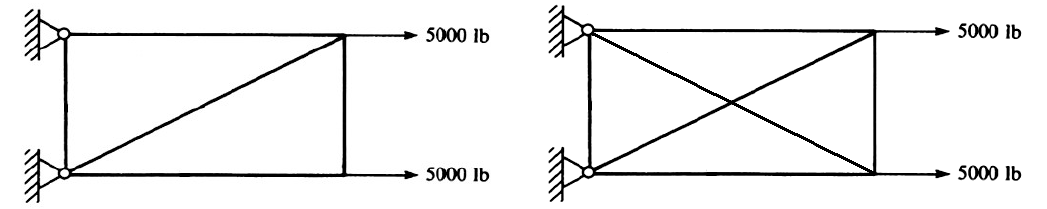
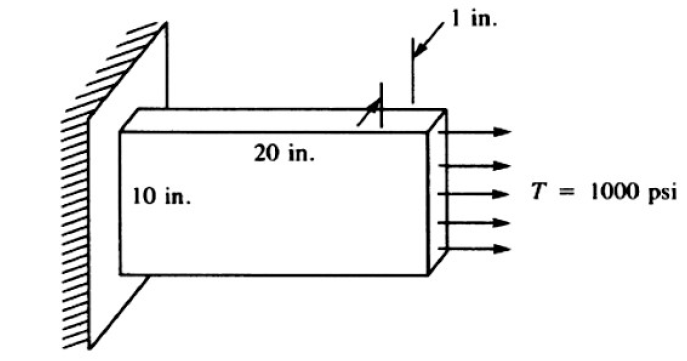

In [32]:
import numpy as np

#Datos
E = 30e6  #[psi]
v = 0.3   #Relacion poison
espesor = 1   #[inch]

T_dist = 1000   #[psi] Tension aplicada distribuida

#Caso 1:
'''
MN = np.array([[0, 0],
               [0, 10],
               [20, 10],
               [20, 0]
              ])

MC = np.array([[0, 1, 2],     #Armo los triangulos
               [0, 2, 3]
              ])

MNE = np.array([ [0,0,0],      #Matriz de nodos empotrados [nodo, ux, uy]
                 [1,0,0] ])
MNT = np.array([ [2,5000,0],   #Matriz de nodos traccionados [nodo, Fx, Fy]
                 [3,5000,0] ])
'''
##--------------------------------------------------##

#Caso 2:
MN = np.array([[0, 0],
               [0, 10],
               [20, 10],
               [20, 0],
               [10, 5]
              ])

MC = np.array([[0, 1, 4],     #Armo los triangulos
               [1, 2, 4],
               [2, 3, 4],
               [0, 3, 4]
              ])

MNE = np.array([ [0,0,0],      #Matriz de nodos empotrados [nodo, ux, uy]
                 [1,0,0] ])
MNT = np.array([ [2,5000,0],   #Matriz de nodos traccionados [nodo, Fx, Fy]
                 [3,5000,0] ])

#---------------------------------------###

cant_nodos = len(MN[:])            #Cantidad de nodos en el problema
cant_elem = len(MC[:])
glxn = 2                           #Grados de libertad por nodo


#Vectores fuerza y desplazamiento
u = np.zeros(2*cant_nodos)
F = np.zeros(2*cant_nodos)

#Matrices del problema
Matriz_D = (E/(1-v**2))*np.array([[1, v, 0], [v, 1, 0], [0, 0, 0.5*(1-v)]])

Matriz_K = np.zeros([glxn*cant_nodos, glxn*cant_nodos])   #Matriz global
Matriz_coor = np.ones((3,3)) 
Matriz_loc_B = []
areas = []


In [33]:
for e in range(cant_elem):
    i, m, j = MC[e]    #Nodos de cada elemento

    x = np.array([MN[i,0],MN[m,0],MN[j,0]])  #coordenada x de cada elemento
    y = np.array([MN[i,1],MN[m,1],MN[j,1]])  #coordenada y de cada elemento
   
    #Ai,j,m = 0 luego de derivar las Ni
    Bi = y[2] - y[1]; Bj = y[1] - y[0]; Bm = y[0] - y[2]
    Gi = x[1] - x[2]; Gj = x[0] - x[1]; Gm = x[2] - x[0]
    #print(Bi, Bj, Bm)
    #print(Gi, Gj, Gm)
    
    #armo la matriz de coordenadas
    Matriz_coor[:,1] = x
    Matriz_coor[:,2] = y
    
    area = np.linalg.det(Matriz_coor)/2   #Obtengo A
    areas.append(area)
    
    #Armo matriz para las deformaciones (deriv de u), derivadas de funcion interp (N_i,j,m):
    Matriz_B = (1/(2*abs(area)))*np.array([[Bi, 0, Bm, 0, Bj, 0], [0, Gi, 0, Gm, 0, Gj], [Gi, Bi, Gm, Bm, Gj, Bj]])   
    Matriz_loc_B.append(Matriz_B)
    
    #Armo la matriz global
    Matriz_local = espesor * abs(area) * (np.dot(np.transpose(Matriz_B), np.dot(Matriz_D, Matriz_B)))
    ind_glob = np.array([2*i, 2*i+1, 2*m, 2*m+1, 2*j, 2*j+1])  #Posiciones en la matriz global (elementos 0, 1, 2 y 3)
    Matriz_K[np.ix_(ind_glob, ind_glob)] += Matriz_local


In [34]:
#Matriz_D*(0.91/30e6)
#Matriz_K[np.ix_(ind_glob, ind_glob)] = 1
print(Matriz_K*(0.91/375000))
#Matriz_loc_B[0]*200
#areas


[[ 48.   26.   -4.    1.    0.    0.    4.   -1.  -48.  -26. ]
 [ 26.   87.   -1.  -36.5   0.    0.    1.   36.5 -26.  -87. ]
 [ -4.   -1.   48.  -26.    4.    1.    0.    0.  -48.   26. ]
 [  1.  -36.5 -26.   87.   -1.   36.5   0.    0.   26.  -87. ]
 [  0.    0.    4.   -1.   48.   26.   -4.    1.  -48.  -26. ]
 [  0.    0.    1.   36.5  26.   87.   -1.  -36.5 -26.  -87. ]
 [  4.    1.    0.    0.   -4.   -1.   48.  -26.  -48.   26. ]
 [ -1.   36.5   0.    0.    1.  -36.5 -26.   87.   26.  -87. ]
 [-48.  -26.  -48.   26.  -48.  -26.  -48.   26.  192.    0. ]
 [-26.  -87.   26.  -87.  -26.  -87.   26.  -87.    0.  348. ]]


In [35]:
#Condiciones de contorno:

#d0x = d0y = d1x = d1y = 0  (lado empotrado)
#F2y = F3y = 0; F2x = F3x = 5000

desplaz = np.zeros(cant_nodos*2)   #Vector con los desplazamiento x, y de todos los nodos
fuerza = []    #Fuerzas conocidas
nodos = []     #Nodos en los que conozco la fuerza pero no desplazamiento, (carga el vector desplaz)

#Necesito los indices de los desp conocidos para reducir la matriz global
for i in MNT:
    nodo, valx, valy = i
    nodos.append(2*nodo)    #Nodos para calcular los desplazamientos
    nodos.append(2*nodo+1)
    fuerza.append(valx)
    fuerza.append(valy)
    
for i in MNE:
    nodo, valx, valy = i
    desplaz[2*nodo] = valx  #Cargo los nodos cuyo desplazamiento ya conozco
    desplaz[2*nodo+1] = valy

#CALCULO LOS DESPLAZAMIENTOS:
#Matriz reducida

Matriz_red = Matriz_K[np.ix_(nodos, nodos)]
fuerza = np.array(fuerza).reshape(-1,1)

desplaz_incog = np.linalg.solve(Matriz_red, fuerza)     

for i, n in enumerate(nodos):
    desplaz[n] = desplaz_incog[i]

#CALCULO LAS FUERZAS:

fuerza_tot = np.dot(Matriz_K, desplaz).round(4)


In [36]:
#fuerza_tot


In [37]:
#TENSIONES
tensiones = []
for e in range(cant_elem):
    i, m, j = MC[e]
    
    #Selecciono los desplazamientos de los nodos de cada elemento
    desp_elem = np.array([[desplaz[2*i], desplaz[2*i+1],desplaz[2*m], desplaz[2*m+1],desplaz[2*j], desplaz[2*j+1]]])  
    tension = np.dot(Matriz_D, np.dot(Matriz_loc_B[e], desp_elem.reshape(-1,1)))
    tensiones.append(tension)


In [38]:
tensiones

[array([[0.],
        [0.],
        [0.]]),
 array([[451.23726346],
        [-53.8573508 ],
        [323.1441048 ]]),
 array([[ 9.02474527e+02],
        [-1.07714702e+02],
        [-7.81876567e-14]]),
 array([[-451.23726346],
        [  53.8573508 ],
        [ 323.1441048 ]])]

In [39]:
desplaz/(10e-7)

array([  0.        ,   0.        ,   0.        ,   0.        ,
       311.59631247, -63.07617661, 311.59631247,  63.07617661,
         0.        ,   0.        ])

[[ 0  0]
 [ 0 10]
 [20 10]
 [20  0]
 [10  5]]


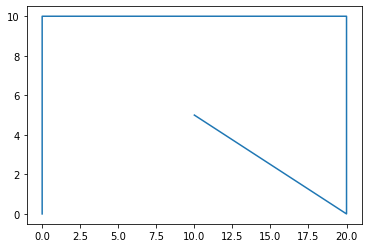

In [52]:
import matplotlib.pyplot as plt
print(MN[:])
plt.plot(MN[:,0], MN[:,1])